# GeoPandas: Pandas + datos de tipo geometría, para datos vectoriales

[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2023-02-28

[GeoPandas](http://geopandas.org) adds a spatial geometry data type to `Pandas` and enables spatial operations on these types, using [shapely](http://toblerity.org/shapely/). GeoPandas leverages Pandas together with several core open source geospatial packages and practices to provide a uniquely simple and convenient framework for handling geospatial feature data, operating on both geometries and attributes jointly, and as with Pandas, largely eliminating the need to iterate over features (rows). Also as with Pandas, it adds a very convenient and fine-tuned plotting method, and read/write methods that handle multiple geospatial file and "serialization" formats.

## Importar paquetes y establecer la ruta de carpeta de datos

Usaremos estos paquetes a lo largo del tutorial.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [2]:
mpl.__version__, pd.__version__, gpd.__version__

('3.7.0', '1.5.3', '0.12.2')

In [3]:
datos_ruta = Path("./datos")

## GeoSeries: El componente geométrico básico

Like a Pandas `Series`, a `GeoSeries` is the building block for the more broadly useful and powerful `GeoDataFrame` that we'll focus on in this tutorial. Here we'll first take a bit of time to examine a `GeoSeries`.

A `GeoSeries` is made up of an index and a GeoPandas `geometry` data type. This data type is a [shapely.geometry object](http://toblerity.org/shapely/manual.html#geometric-objects), and therefore inherits their attributes and methods such as `area`, `bounds`, `distance`, etc.

GeoPandas has six classes of **geometric objects**, corresponding to the three basic single-entity geometric types and their associated homogeneous collections of multiple entities:
- **Single entity (core, basic types):**
  - Point
  - Line (*formally known as a LineString*)
  - Polygon
- **Homogeneous entity collections:**
  - Multi-Point
  - Multi-Line (*MultiLineString*)
  - Multi-Polygon

A `GeoSeries` is then a list of geometry objects and their associated index values.

<div class="alert alert-warning" style="font-size:100%">
<b style="font-size:120%">Entries (rows) in a GeoSeries can store different geometry types!</b></br></br>

GeoPandas does not constrain the geometry column to be of the same geometry type. This can lead to unexpected problems if you're not careful! Specially if you're used to thinking of a GIS file format like shape files, which store a single geometry type. Also beware that certain export operations (say, to shape files ...) will fail if the list of geometry objects is heterogeneous.
</div>

### Crear una `GeoSeries` de una lista de objetos `shapely Point` usando el constructor `Point`

In [4]:
gs = GeoSeries([Point(-120, 45), Point(-121.2, 46), Point(-122.9, 47.5)])
gs

0    POINT (-120.00000 45.00000)
1    POINT (-121.20000 46.00000)
2    POINT (-122.90000 47.50000)
dtype: geometry

In [5]:
type(gs), len(gs)

(geopandas.geoseries.GeoSeries, 3)

De vez en cuando, te puedes encontrar con la necesidad de analizar y convertir una geometría en el formato de un string `WKT`. Un objecto `shapely Point` puede ser construido basado en ese string con `shapely.wkt.loads`:

```python
from shapely.wkt import loads
loads('POINT(-121.2 46)')
```



Una `GeoSeries` (y un `GeoDataFrame`) puede almacenar un objeto `CRS` (en español: SCR, Sistema de Coordenadas de Referencia) asociado implícitamente con la columna de geometría, `geometry`. Esto es muy útil como metadatos espaciales esenciales y para la transformación (reproyección) a otro CRS. Aquí, vamos a asignar un CRS a `gs` y luego graficarlo.

In [6]:
gs = gs.set_crs('epsg:4326')

In [7]:
gs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

El método `plot` acepta opciones de estilo estandard de `matplotlib.pyplot`, y puede ser personalizado como cualquier otra figura (plot) de `matplotlib`.

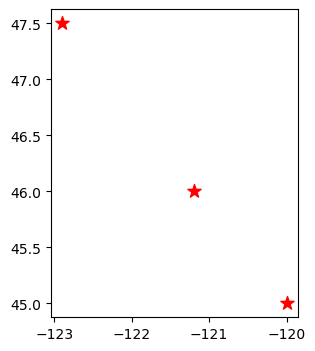

In [8]:
gs.plot(marker='*', color='red', markersize=100, figsize=(4, 4));

**Ahora haremos más, acercándonos hacia un `GeoDataFrame`.** Primero, definimos un diccionario simple de listas, que reusaremos más tarde.

In [9]:
datos = {
    'nombre': ['a', 'b', 'c'],
    'lat': [45, 46, 47.5],
    'lon': [-120, -121.2, -122.9]
}

Fíjense en el mecanismo compacto y conveniente para crear una lista de objetos `Point` de `shapely` basado en una lista de coordenadas X & Y, utilizand el método `gpd.points_from_xy`. Podríamos obtener el mismo resultado de esta manera más verbosa: `geometry = [Point(x,y) for x,y in zip(datos['lon'], datos['lat'])]`.

In [10]:
geometria = gpd.points_from_xy(datos['lon'], datos['lat'])

Por último, creamos una `GeoSeries` dónde definimos los valores del índice explícitamente.

In [11]:
gs = GeoSeries(geometria, index=datos['nombre'])
gs

a    POINT (-120.00000 45.00000)
b    POINT (-121.20000 46.00000)
c    POINT (-122.90000 47.50000)
dtype: geometry

## GeoDataFrames: El poder completo de Pandas y objetos geométricos

<div class="alert alert-info" style="font-size:100%">

Vale la pena mencionar que un GeoDataFrame puede ser descrito como un **Feature Collection** (Colección de Entidades), dónde cada hilera representa un *Feature* (Entidad) y una columna tipo `geometry` es definida (aunque el nombre de la columna no tiene que ser `geometry`), y las *propiedades* incluyen las otras colúmnas (la parte que corresponde a un *Pandas DataFrame*)

</div>

<div class="alert alert-warning" style="font-size:100%">

Pueden existir más de una columna con objetos de tipo `geometry`! No exploraremos esta capacidad en este tutorial.

</div>

### Comencemos con una ilustración simple construída manualmente

Reusemos el diccionario `datos` que definimos anteriormente, ahora para crear un `DataFrame`.

In [12]:
df = pd.DataFrame(datos)
df

,nombre,lat,lon
0,a,45.0,-120.0
1,b,46.0,-121.2
2,c,47.5,-122.9


Ahora usamos el DataFrame y `points_from_xy` (que crea una lista de objetos shapely Point) para crear un GeoDataFrame. Observen el uso de dos columnas del `DataFrame`, que en realidad son dos simples `Series` de `Pandas`.

In [13]:
gdf = GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

gdf

,nombre,lat,lon,geometry
0,a,45.0,-120.0,POINT (-120.00000 45.00000)
1,b,46.0,-121.2,POINT (-121.20000 46.00000)
2,c,47.5,-122.9,POINT (-122.90000 47.50000)


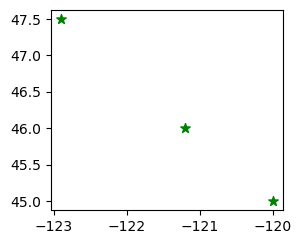

In [14]:
gdf.plot(marker='*', color='green', markersize=50, figsize=(3, 3));

### Ahora sí vamos a trabajar con datos reales, comenzando con datos globales de mares

`gpd.read_file` se usa para leer todo tipo de archivos SIG. Utiliza el paquete [fiona](http://toblerity.org/fiona/README.html).

In [15]:
mares = gpd.read_file(datos_ruta / "World_Seas.shp")

El `crs` es leído automáticamente del archivo `prj` del `shape file`:

In [16]:
mares.crs.to_epsg()

4326

In [17]:
mares.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        101 non-null    object  
 1   ID          101 non-null    object  
 2   Gazetteer   101 non-null    int64   
 3   is_generic  101 non-null    object  
 4   Oceans      101 non-null    object  
 5   geometry    101 non-null    geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 4.9+ KB


In [18]:
mares.head()

,NAME,ID,Gazetteer,is_generic,Oceans,geometry
0,Inner Seas off the West Coast of Scotland,18,4283,False,North Atlantic Ocean,"POLYGON ((-6.49695 58.08749, -6.51324 58.08596..."
1,Mediterranean Sea - Western Basin,28A,4279,False,North Atlantic Ocean,"POLYGON ((12.43080 37.80325, 12.41499 37.79510..."
2,Mediterranean Sea - Eastern Basin,28B,4280,False,North Atlantic Ocean,"POLYGON ((23.60854 35.60875, 23.60121 35.60048..."
3,Sea of Marmara,29,3369,False,North Atlantic Ocean,"POLYGON ((26.21791 40.05291, 26.23277 40.06086..."
4,Black Sea,30,3319,False,North Atlantic Ocean,"POLYGON ((29.04846 41.25555, 29.03867 41.24972..."


Y ahora podemos graficar un mapa de una manera muy sencilla pero útil.

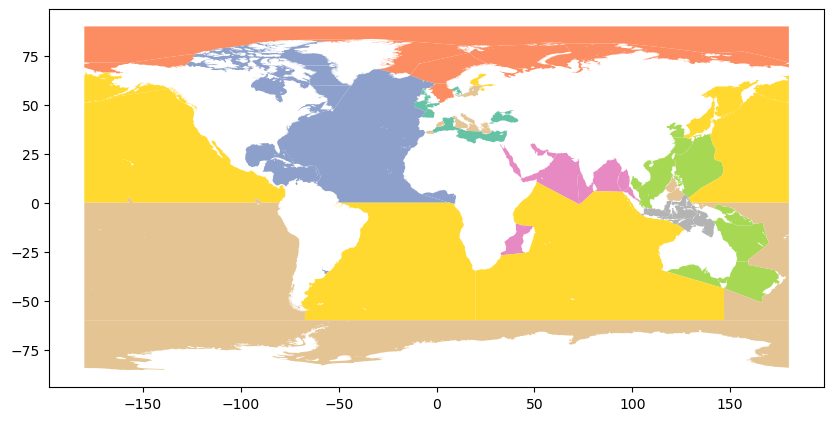

In [19]:
mares.plot(cmap='Set2', figsize=(10, 10));

`World_Seas.shp` almacena geomtrías tanto de `Polygon` como `Multi-Polygon` (un `Polygon` puede ser visto como un `Multi-Polygon` con 1 miembro). Podemos acceder al tipo `geometry` y otras propiedades geométricas fácilmente.

In [20]:
mares.geom_type.value_counts()

Polygon         96
MultiPolygon     5
dtype: int64

In [21]:
# Cuidado! Estos cálculos de área son en unidades de grados, que no son muy útiles
mares.geometry.area.head()

0      6.397648
1     49.930643
2    114.174214
3      1.266067
4     46.805060
dtype: float64

In [22]:
mares.geometry.bounds.head()

,minx,miny,maxx,maxy
0,-8.219077,54.385555,-4.485418,58.624164
1,-2.192082,35.551109,12.430800,43.790973
2,10.007082,30.263882,36.217282,37.803255
3,26.164409,39.991100,29.937500,41.246245
4,27.449582,40.910273,41.776091,47.252355


El método `envelope` (sobre) retorna la caja de borde (bounding box) por cada polígono. Esto puede ser usado para crear una nueva columna o GeoSeries espacial; para graficar direcatemente; etc.

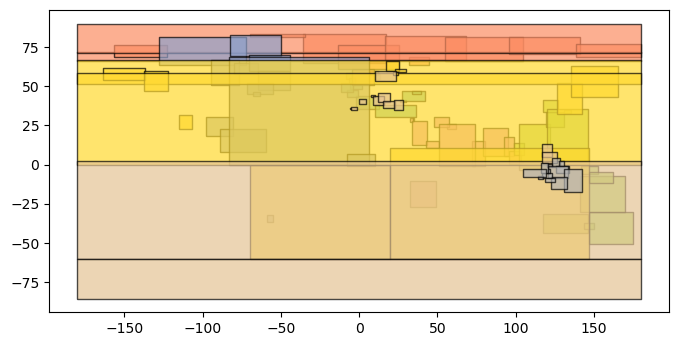

In [23]:
mares.envelope.plot(cmap='Set2', figsize=(8, 8), alpha=0.7, edgecolor='black');

Podemos filtrar y graficar:

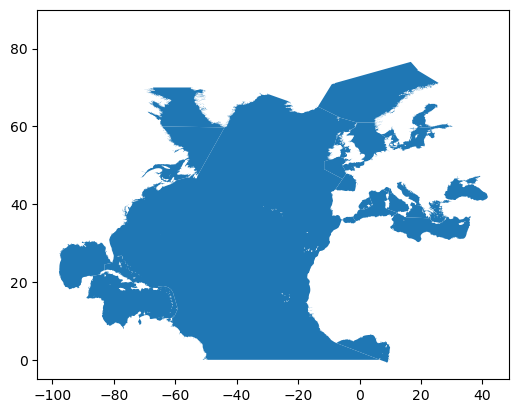

In [24]:
mares[mares['Oceans'] == 'North Atlantic Ocean'].plot()
plt.ylim([-5, 90]);

### Carguemos el dataset de países de "Natural Earth", que viene con GeoPandas
*"[Natural Earth](http://www.naturalearthdata.com) is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software."* 

Un pequño subset de Natural Earth viene con GeoPandas y es accesible a través del módulo `gpd.datasets`. Podemos usarlo como un mapa global de base.

In [25]:
paises = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
paises.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


Su CRS también es EPSG:4326:

In [26]:
paises.crs.to_epsg()

4326

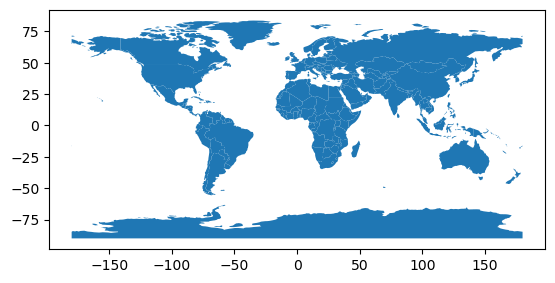

In [27]:
paises.plot();

### "overlays" de mapas: Graficando varios capas espaciales

Esta es una manera compacta y rápida de usar el método `plot` de un GeoDataFrame para hacer overlay (poner uno sobre otro) dos GeoDataFrames mientras personalizamos los estilos de cada capa. La gráfica (plot) "interior" (`mares`) es mostrado en el fondo.

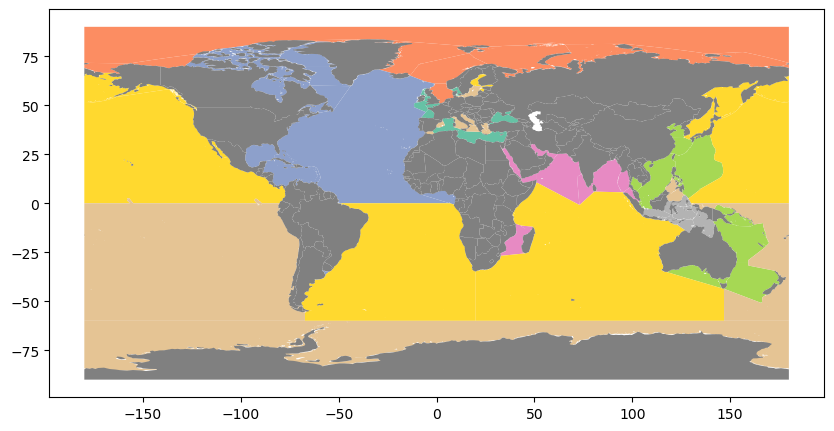

In [28]:
paises.plot(ax=mares.plot(cmap='Set2', figsize=(10, 10)), 
           facecolor='gray');

También podemos crear un plot usando los pasos convencionales de `matplotlib` junto con opciones que nos dan más control.

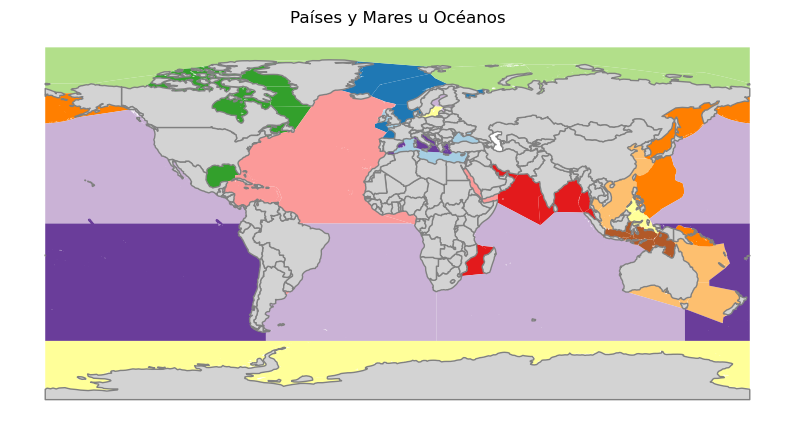

In [29]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.set_title('Países y Mares u Océanos')
# Otros color maps (cmap) categóricos buenos incluyen 'Set2' y 'Set3'
mares.plot(ax=ax, cmap='Paired')
paises.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">¿Preguntas?</b></br>

¿Hay alguna pregunta o duda?

</div>

## Temas más avanzados

### Gráficas y filtraciones de datos más avanzados

Colorizar la capa basado en una columna que agrega polígonos individuales, usando un mapa categórico, como antes, pero seleccionando explícitamente la columna (`column='Oceans'`) y la opción de mapeo categórico (`categorical=True`); y mostrando una leyenda auto-generada. Cada item de "Oceans" contiene uno o más mares.

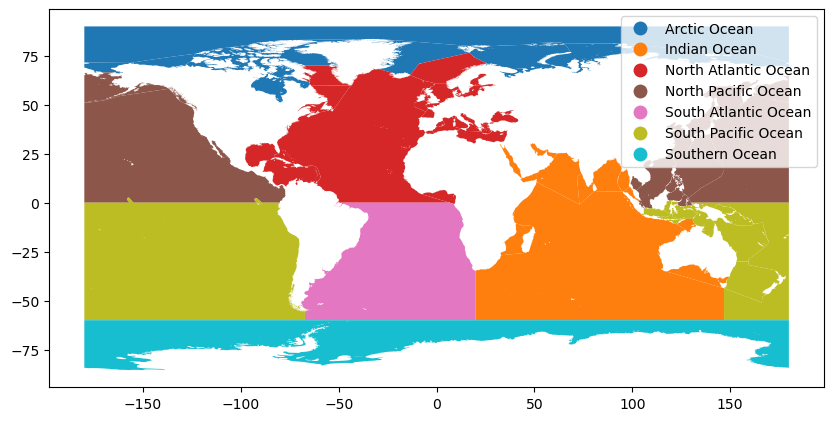

In [30]:
mares.plot(column='Oceans', categorical=True, legend=True, figsize=(10, 5));

**Combinemos lo que hemos aprendido.** Un overlay de mapa, usando `paises` como la capa de fondo, y filtrando `mares` basado en valores de las columnas (la columna `Oceans`) y el atributo automático del objeto `geometry` de GeoPandas. `paises` está en gris y los `mares` filtrados en color.

In [31]:
mares.centroid.y.head(2)

0    56.404019
1    39.344895
dtype: float64

In [32]:
mares_atlanticonorte_occidental_gdf = mares[
    (mares['Oceans'] == 'North Atlantic Ocean') 
    & (mares.centroid.x < -20)
    & (mares.centroid.y < 40)
]

In [33]:
len(mares_atlanticonorte_occidental_gdf)

3

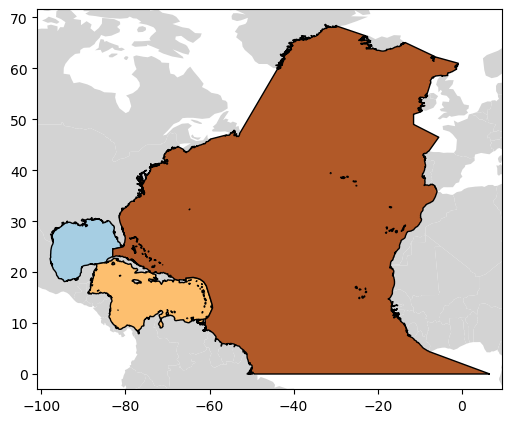

In [34]:
mares_atlanticonorte_occidental_gdf.plot(
    ax=paises.plot(facecolor='lightgray', figsize=(6, 6)), 
    cmap='Paired', edgecolor='black'
)

# Usamos el atributo geométrico bounds para establecer una extensión 
# geográfica apropiada para el plot, basado en el GeoDataFrame filtrado
bounds = mares_atlanticonorte_occidental_gdf.geometry.bounds

plt.xlim([bounds.minx.min()-3, bounds.maxx.max()+3])
plt.ylim([bounds.miny.min()-3, bounds.maxy.max()+3]);

### Guardar el GeoDataFrame de los mares filtrados a un archivo SIG en formato `geopackage`

El método `to_file` utiliza el paquete [fiona](http://toblerity.org/fiona/README.html) para escribir a archivos SIG. El `driver` por defecto es el 'ESRI Shapefile', pero muchos otros formatos están disponibles porque `fiona` utiliza el software [GDAL/OGR](http://www.gdal.org).

In [35]:
mares_atlanticonorte_occidental_gdf.to_file("mares_atlanticonorte_occidental.gpkg")

### Leer datos vectoriales de un servicio OGC WFS con respuesta en formato GeoJSON, a un GeoDataFrame
Usar una solicitud (request) del servicio estandard [Open Geospatial Consortium](http://www.opengeospatial.org) (OGC) [Web Feature Service](https://en.wikipedia.org/wiki/Web_Feature_Service) (WFS) para obtener datos geoespaciales de un servidor remoto. OGC WFS es un estandard geoespacial abierto.

No entraremos en detalle. Suficiente con decir que ejecutamos una solicitud OGC WFS de todos los features (entidades) de la capa 'geonode:wld_trs_ports_wfp' que se encuentra en un servidor del Programa Mundial de la Salud (WFP), solicitando datos en formato `GeoJSON`. Luego usamos el paquete [geojson](https://github.com/frewsxcv/python-geojson) para cargar la respuesta cruda (string GeoJSON) a un objeto de entidades `geojson`, que funciona como un diccionarios.

Esta capa es una base de datos global de puertos, representados como puntos.

In [36]:
import requests
import geojson

puertos_wfs_url = "https://geonode.wfp.org/geoserver/wfs"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='geonode:wld_trs_ports_wfp', outputFormat='json',
              srsName="EPSG:4326",
              hdx='hdx')

r = requests.get(puertos_wfs_url, params=params)
puertos_geojson = geojson.loads(r.content)

Ahora utilizamos el constructor `from_features` para crear un GeoDataFrame diréctamente (de un objeto `geojson.feature.FeatureCollection`).

In [37]:
puertos_gdf = GeoDataFrame.from_features(puertos_geojson, crs='epsg:4326')

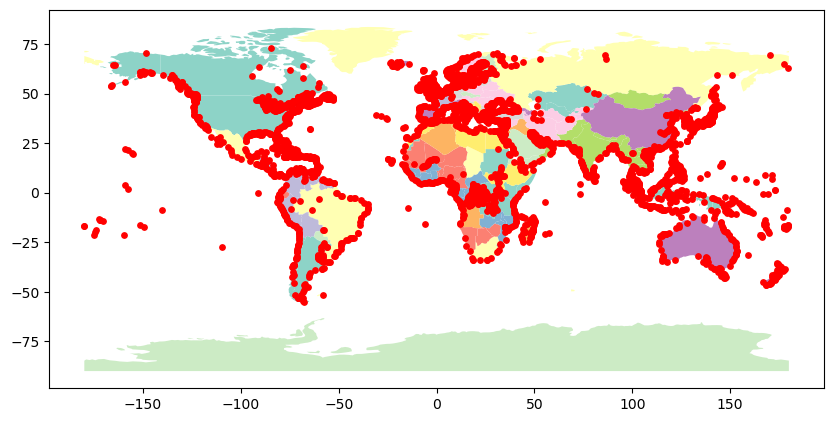

In [38]:
puertos_gdf.plot(ax=paises.plot(cmap='Set3', figsize=(10, 6)),
             marker='o', color='red', markersize=15);

In [39]:
puertos_gdf.iloc[-1]

geometry             POINT (179.42398 -17.353273)
portname                               Koro Jetty
code                                         None
prttype                                       Sea
prtsize                                Very Small
status                                    Unknown
maxdepth                                      NaN
maxlength                                     NaN
annualcapacitymt                              NaN
humuse                                       None
locprecision                             accurate
latitude                                -17.35327
longitude                               179.42398
iso3                                          FJI
iso3_op                                      None
country                                      Fiji
lastcheckdate                                None
remarks                                      None
url_lca                                      None
source                                       None


### Interseccion, puertos y mares

Seleccionemos puertos en el Golfo de California, usando un "spatial join"

In [40]:
puertos_golfocalifornia_gdf = gpd.sjoin(puertos_gdf, mares[mares["NAME"] == "Gulf of California"], how="inner")

In [41]:
len(puertos_golfocalifornia_gdf)

3

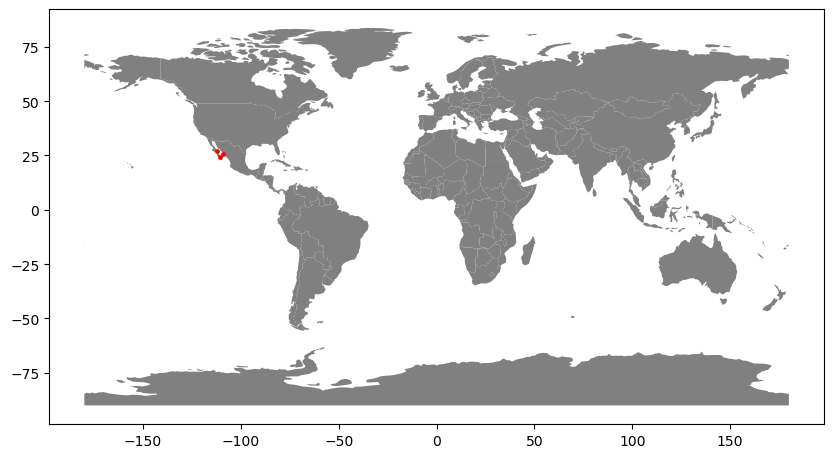

In [42]:
puertos_golfocalifornia_gdf.plot(
    ax=paises.plot(facecolor='gray', figsize=(10, 10)), 
    color='red', 
    markersize=6
);

### Disolver polígonos

Unificar polígonos basado en atributos comunes.

In [43]:
mares_natl_disolv_gdf = (
    mares_atlanticonorte_occidental_gdf[['Oceans', 'geometry']]
    .dissolve(by='Oceans', aggfunc='first', as_index=False)
)

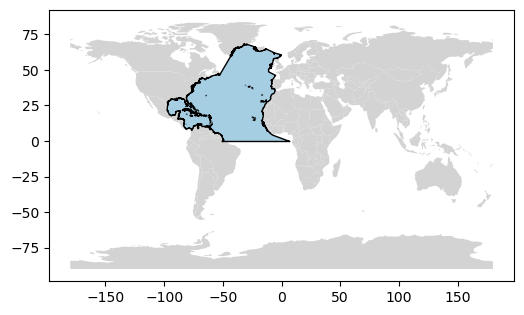

In [44]:
mares_natl_disolv_gdf.plot(
    ax=paises.plot(facecolor='lightgray', figsize=(6, 6)), 
    cmap='Paired', edgecolor='black'
);